<a href="https://colab.research.google.com/github/zsiki/AttributeSplit/blob/master/hungarian/image_processing/img_def_hu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Mozgás és deformáció vizsgálat fényképekből

##Alapelvek

*   Mozdulatlan kamerával készítünk képeker vagy videókat. A kamera nem mozdulhat el
*   Kalibrált kamerával növelhetjük a pontosságot
*   A képek felbontását egy geodézia távcső közbeiktatásával növelhetjük


##Módszerek

*   Mintaillesztés (Template matching)
*   Alakfelismerés (Pattern recognition)

###Mintaillesztés jellemzői

Előnyök

*   mindig van találat
*   egyszerű algoritmus
*   Nincs szükség speciális jelre

Hátrányok

*   hamis találat esélye magas lehet
*   csak minimális elfordulás engedhető meg
*   csak minimális méretváltozás engedhető meg

###Alakfelismerés

Előnyök

*   a jel elfordulhat
*   jel mérete megváltozhat
*   a jel orientációja becsülhető

Hátrányok

*   Speciális jelet kell elhelyezni
*   érzékenyebb a fényviszinyokra


Először importáljuk a szükséges Python csomagokat!

In [1]:
import glob                         # to extend file name pattern to list
import cv2                          # OpenCV for image processing
from cv2 import aruco               # to find ArUco markers
import numpy as np                  # for matrices
import matplotlib.pyplot as plt     # to show images
cv2.__version__

'4.8.0'

##Mintaillesztés

Töltsünk le egy képet a munkához.

In [2]:
!wget -q -O sample_data/monalisa.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/monalisa.jpg

A képből kivágunk egy mintát (az arcot) és mindkettőt szűrkeárnyalatossá alaktjuk. A képen alkalmazunk egy simító szűrőt, hogy nehezebbé tegyük a minta megtalálását.

képméret: (276, 182)  mintaméret: (76, 52)


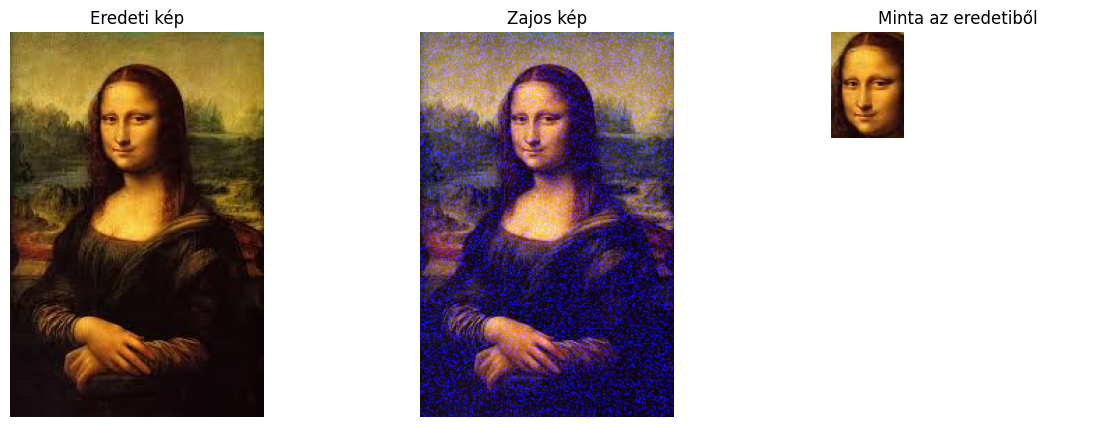

In [3]:
img = cv2.imread('sample_data/monalisa.jpg')          # load image
row0 = 25; col0 = 57; row1 = row0 + 76; col1 = col0 + 52
templ = img[row0:row1, col0:col1,:]
mean = 0; stddev = 180
noise = np.zeros(img.shape, np.uint8)
cv2.randn(noise, mean, stddev)
img_noise = cv2.add(img, noise)                             # véletlen zaj hozzáadása a képhez
img_gray = cv2.cvtColor(img_noise, cv2.COLOR_BGR2GRAY)      # kép szürkeárnyalatossá konvertálása
templ_gray = cv2.cvtColor(templ, cv2.COLOR_BGR2GRAY)        # minta szürkeárnyalatossá konvertálása
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))  # kép és minta megjeleítése
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Eredeti kép')
ax1.axis("off")
ax2.imshow(cv2.cvtColor(img_noise, cv2.COLOR_BGR2RGB))
ax2.set_title('Zajos kép')
ax2.axis("off")
ax3.imshow(cv2.cvtColor(templ, cv2.COLOR_BGR2RGB))    # BGR vs. RGB !
ax3.set_title('Minta az eredetiből')
ax3.set_xlim(ax1.get_xlim())                          # méretarány egyformára
ax3.set_ylim(ax1.get_ylim())
ax3.axis("off")
print(f'képméret: {img_gray.shape}  mintaméret: {templ_gray.shape}')

*Módosítsa a fenti kódot, hogy szürkeárnyalatos képek jelenjenek meg!*


Az OpenCV tartalmaz egy függvényt a mintaillesztésre. A *matchTemplate* hat különböző szatisztikával dolgozhat. A *TM_CCOEFF_NORMED* a normalizált együtthatót számítja, az értéke (0, 1) között lesz, az 1 jelenti a tökéletes egyezést.

Legjobb egyezés: (57, 25) érték: 98.80%%


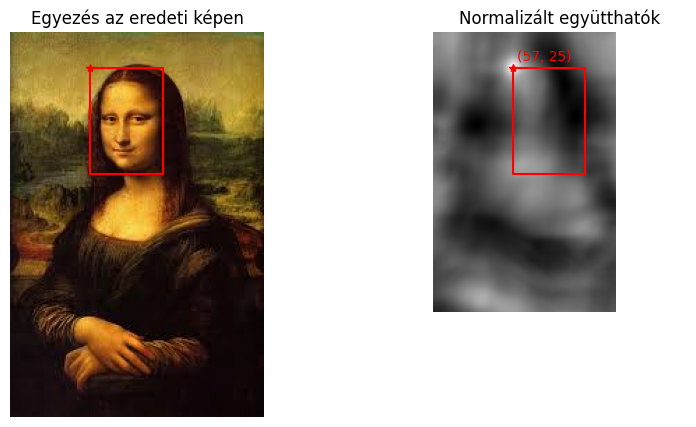

In [5]:
result = cv2.matchTemplate(img_gray, templ_gray, cv2.TM_CCOEFF_NORMED)
val, _, max = cv2.minMaxLoc(result)[1:4]        # get position of best match
fr = np.array([max,                             # template frame in image
               (max[0]+templ.shape[1], max[1]),
               (max[0]+templ.shape[1], max[1]+templ.shape[0]),
               (max[0], max[1]+templ.shape[0]),
               max])
result_uint = ((result - np.min(result)) / (np.max(result) - np.min(result)) * 256).astype('uint8')
result_img = cv2.cvtColor(result_uint, cv2.COLOR_GRAY2BGR)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
ax1.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
ax1.set_title('Egyezés az eredeti képen')
ax1.plot(fr[:,0], fr[:,1], 'r')
ax1.plot([max[0]],[max[1]], 'r*')
ax1.axis("off")
ax2.imshow(result_img)
ax2.plot(fr[:,0], fr[:,1], 'r')
ax2.plot([max[0]],[max[1]], 'r*')
ax2.set_title('Normalizált együtthatók')
ax2.set_xlim(ax1.get_xlim())                          # set same scale
ax2.set_ylim(ax1.get_ylim())
ax2.annotate(str(max), (max[0]+3, max[1]-5), color='Red')
ax2.axis("off")
print(f'Legjobb egyezés: {max} érték: {val:.2%}%')

*Módosítsa a fenti kódot más statisztika használatához pl. TM_CCORR_NORMED, TM_SQDIFF_NORMED.*

*Módosítsa a minta pozícióját és méretét és futtassa újra.*

*Módosítsa a képhez adott véletlen zaj paramétereit (legyen nagyobb zaj) és futtassa újra.*

###Képtranszformáció

Ha kép és a minta egymáshoz képest elforgatott állapotot ábrázol, akkor a mintakeresés eredménye nem lesz pontos.

Töltsünk le egy másik nem szemből készült Mona Lisa képet.


In [6]:
!wget -q -O sample_data/monalisa_tilt.jpg https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/monalisa_tilt.jpg

Próbáljuk meg a mintánkat megtalálni az elfogatott képen.

Legjobb egyezés (467, 240) 57.40%, DE HIBÁS!


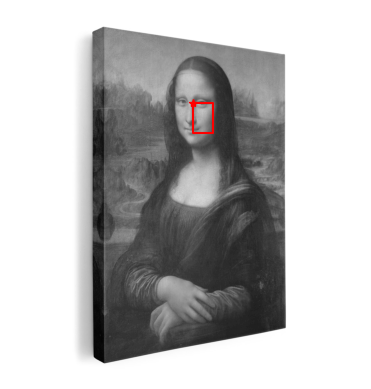

In [8]:
img = cv2.imread('sample_data/monalisa_tilt.jpg', cv2.IMREAD_GRAYSCALE)
result = cv2.matchTemplate(img, templ_gray, cv2.TM_CCOEFF_NORMED)
val, _, max = cv2.minMaxLoc(result)[1:4]
fr = np.array([max,
               (max[0]+templ.shape[1], max[1]),
               (max[0]+templ.shape[1], max[1]+templ.shape[0]),
               (max[0], max[1]+templ.shape[0]),
               max])
plt.imshow(img, cmap="gray")
plt.plot(fr[:,0], fr[:,1], 'r')
plt.plot([max[0]],[max[1]], 'r*')
plt.axis("off")
print(f'Legjobb egyezés {max} {val:.2%}, DE HIBÁS!')

Transzformáljuk vissza az elfordított képet. Ehhez egy függvényt készítünk.

In [9]:
def project_img(image, a_src, a_dst):
    """ transzformációs mátrix számítása """

    new_image = image.copy()                       # make a copy of input image
    # transzformáció paramétereinek számítása
    projective_matrix = cv2.getPerspectiveTransform(a_src, a_dst)
    # kép transzformálása
    transformed = cv2.warpPerspective(img, projective_matrix, image.shape)
    # célterület kivágása
    transformed = transformed[0:int(np.max(a_dst[:,1])),0:int(np.max(a_dst[:,0]))]
    return transformed

Legjobb egyezés (55, 19) érték 91.99%%


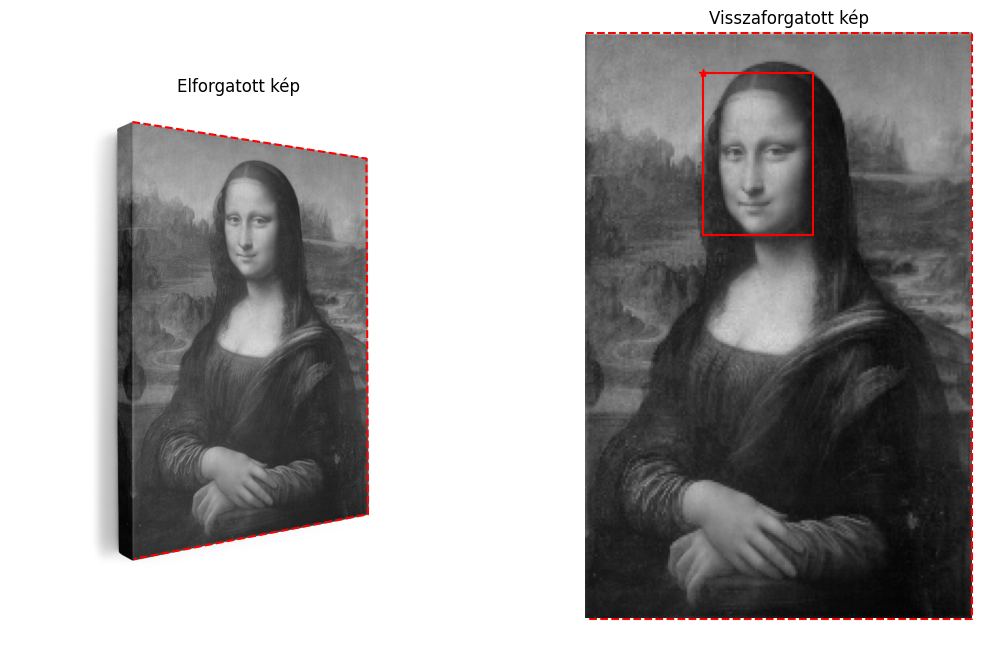

In [ ]:
# képhatárok az elforgatott képen
src = [(240, 44), (700, 116), (703, 815), (243, 903)]
# keret az eredeti képen
s = img_gray.shape
dst = [(0, 0), (s[1], 0), (s[1], s[0]), (0,s[0])]
a_src = np.float32(src)
a_dst = np.float32(dst)
# kép transzformálása
img_dst = project_img(img, a_src, a_dst)
# template match
result = cv2.matchTemplate(img_dst, templ_gray, cv2.TM_CCOEFF_NORMED)
val, _, max = cv2.minMaxLoc(result)[1:4]
# minta körvonala a transzformált képen
fr = np.array([max,
               (max[0]+templ.shape[1], max[1]),
               (max[0]+templ.shape[1], max[1]+templ.shape[0]),
               (max[0], max[1]+templ.shape[0]),
               max])
fig, ax = plt.subplots(1,2, figsize=(13,8))
ax[0].imshow(img, cmap="gray");
ax[0].plot(a_src[:,0], a_src[:,1], 'r--')
ax[0].set_title('Elforgatott kép')
ax[0].axis("off")
ax[1].imshow(img_dst, cmap="gray")
ax[1].plot(a_dst[:,0], a_dst[:,1], 'r--')
ax[1].set_title('Visszaforgatott kép')
ax[1].plot(fr[:,0], fr[:,1], 'r')
ax[1].plot([max[0]],[max[1]], 'r*')
ax[1].axis("off")
print(f'Legjobb egyezés {max} érték {val:.2%}%')

##ArUco jelek felismerése

Az ArUco jel egy négyzet alakú marker, amely széles fekete keretből és egy belső bináris mátrixból áll, amely meghatározza az azonosítóját (id - egy egész érték). A fekete szegély segíti a gyors felismerést a képen, a bináris kódolás pedig az azonosítását, valamint a hibadetektáló és -javító technikák alkalmazását. A jel mérete határozza meg a belső mátrix méretét. Például egy 4x4-es jelméret 16 bitből áll. (*az OpenCV dokumentációból*)

Az OpenCV tartalmaz egy *aruco* nevű kiegészítő csomagot az ArUcojelek felismerésére.


Keressünk ArUco jelek egy egyszerű képen.

In [10]:
!wget -q -O sample_data/markers.png https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/markers.png

In [11]:
img = cv2.imread('sample_data/markers.png')
img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

id   X    Y
16  502  342
15  328  342
14  152  342
13  502  142
12  328  142
11  152  142


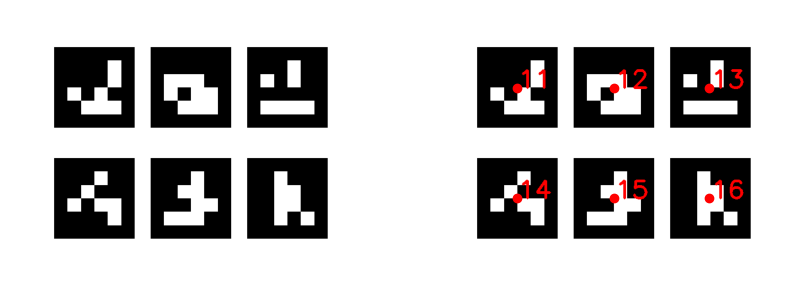

In [14]:
aruco_dict = aruco.getPredefinedDictionary(cv2.aruco.DICT_4X4_100)       # ArUco jelkészlet kiválasztása (4x4)
params = aruco.DetectorParameters()                                      # alapértelmezett paraméterek
# ArUco jelek körvonalának és azonosítójának megkeresése
corners, ids, _ = aruco.detectMarkers(img_gray, aruco_dict, parameters=params)
x = np.zeros(ids.size)
y = np.zeros(ids.size)
img1 = img.copy()
# pixel koordináták kigyűjtése és a középpont és az id megjelenítése a képen
for j in range(ids.size):
  x[j] = int(round(np.average(corners[j][0][:, 0])))
  y[j] = int(round(np.average(corners[j][0][:, 1])))
  cv2.putText(img1, str(ids[j][0]), (int(x[j]+2), int(y[j])), cv2.FONT_HERSHEY_SIMPLEX, 1.5, (255, 0, 0), 3)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(img)
ax[0].axis("off")
ax[1].imshow(img1)
ax[1].plot(x, y, "ro")
ax[1].axis("off")
print("id   X    Y")
print("="*12)
for i in range(ids.size):
    print(f"{ids[i][0]:2d} {int(x[i]):4d} {int(y[i]):4d}")

##Kamera kalibráció

Az olcsó kamerák jelentős torzítással bírhatnak (radiális illetve tangenciális). A kamera kalibrációval csökkenthetjük az optika torzítását.

###Radiális torzítás

$$ x' = x (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) $$
$$ y' = y (1 + k_1 r^2 + k_2 r^4 + k_3 r^6) $$

###Tangenciális torzítás

$$ x' = x + (2 p_1 x y + p_2 (r^2 + 2 x^2)) $$
$$ y' = y + (p_1 (r^2+2 y^2) + 2 p_2 x y) $$

###Kamera mátrix

<table>
<tr><td>f<sub>x</sub></td><td>0</td><td>c<sub>x</sub></td></tr>
<tr><td>0</td><td>f<sub>y</sub></td><td>c<sub>y</sub></td></tr>
<tr><td>0</td><td>0</td><td>1</td></tr></table>


A torzítási paraméterek ($ k_1, k_2, k_3, p_1, p_2 $). A kamera mátrix tartalmazza a fókusztávolságot ($ f_x, f_y $) és a képfőpont koordinátáit ($ c_x, c_y $).

A kalibrációhoz egy sakktábla szerű alakzatról kell több különböző irányból képet készíteni. ArUco jeleket is tartalmazó úgynevezett Charuco táblát használunk.

Töltsünk le ilyen képeket vagy készítsünk magunk fényképeket!

In [12]:
!wget -q -O sample_data/cal.zip https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/cal.zip
!unzip -q -o sample_data/cal.zip -d sample_data

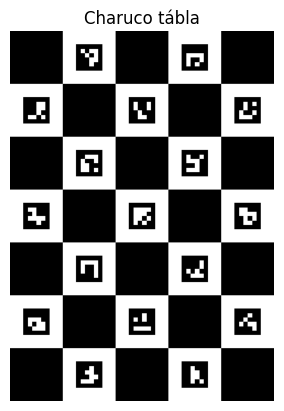

In [15]:
width = 5       # Charuco tábla mérete
height = 7
board = aruco.CharucoBoard((width, height), .025, .0125, aruco_dict)   # tábla generálása a memóriában
img = board.generateImage((500, 700))
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.axis("off")
_ = plt.title('Charuco tábla')

Az első hat kép a kalibrációhoz:

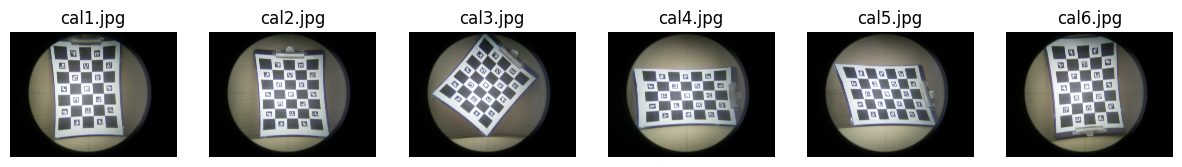

In [16]:
fig, ax = plt.subplots(1, 6, figsize=(15, 2))
for i in range(6):
    im = cv2.imread('sample_data/cal{:d}.jpg'.format(i+1))
    ax[i].imshow(cv2.cvtColor(im, cv2.COLOR_BGR2RGB))
    ax[i].set_title('cal{:d}.jpg'.format(i+1))
    ax[i].axis("off")

Számítsuk ki a képek alapján a radiális és tangenciális torzítás paramétereit és a kamera mátrixot.

In [17]:
allCorners = []
allIds = []
decimator = 0

for name in glob.glob("sample_data/cal*.jpg"):
  frame = cv2.imread(name)
  gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
  corners, ids, _ = cv2.aruco.detectMarkers(gray, aruco_dict)
  ret, corners1, ids1 = cv2.aruco.interpolateCornersCharuco(corners, ids, gray, board)
  allCorners.append(corners1)
  allIds.append(ids1)
  decimator += 1

ret, mtx, dist, rvecs, tvecs = cv2.aruco.calibrateCameraCharuco(allCorners, allIds, board, gray.shape, None, None)
print("Kamera mátrix [pixelek]")
for i in range(mtx.shape[0]):
  print(f'{mtx[i][0]:8.1f} {mtx[i][1]:8.1f} {mtx[i][2]:8.1f}')
print('Radiális együtthatók')
print(30 * '-')
print(f'{dist[0][0]:10.5f} {dist[0][1]:10.5f} {dist[0][2]:10.5f}')
print(30 * '-')
print('Tangenciális együtthatók')
print(f'{dist[0][3]:10.5f} {dist[0][4]:10.5f}')

Kamera mátrix [pixelek]
 27978.6      0.0   1371.7
     0.0  26950.4   1440.9
     0.0      0.0      1.0
Radiális együtthatók
------------------------------
  73.97781   -0.80231    0.55304
------------------------------
Tangenciális együtthatók
  -0.62728   -0.16092


Rajzoljuk ki egy kép eredeti és torzítatlan képét.

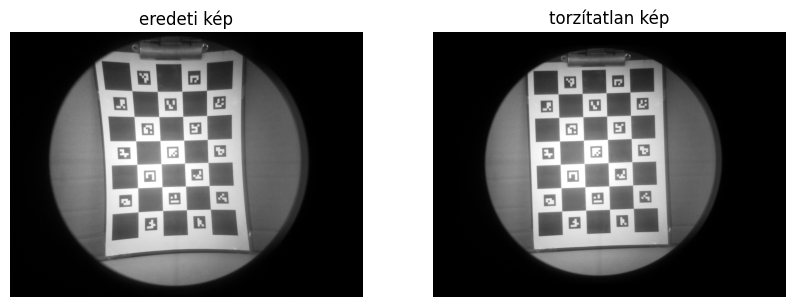

In [18]:
gray = cv2.imread('sample_data/cal1.jpg', cv2.IMREAD_GRAYSCALE)
fig, ax = plt.subplots(1, 2, figsize=(10,5))
ax[0].imshow(gray, cmap='gray')
ax[0].axis("off")
ax[0].set_title('eredeti kép')
ax[1].imshow(cv2.undistort(gray, mtx, dist, None), cmap='gray')
ax[1].axis("off")
_ = ax[1].set_title('torzítatlan kép')

##Komplex példa

Egy videót készítettünk egy mozgó objektumról, melyre egy ArUco jelet rögzítettünk. Dolgozzuk fel a videót képkockákként és ábrázoljuk a jel mozgását. A feldolgozás során a képeket a kalibrációs adatokkal javítjuk.

[Kattintson ide](https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/demo.mp4) a videó megtekintéséhez.




In [20]:
# videó letöltése
!wget -q -O sample_data/demo.mp4 https://raw.githubusercontent.com/OSGeoLabBp/tutorials/master/english/img_processing/code/demo.mp4

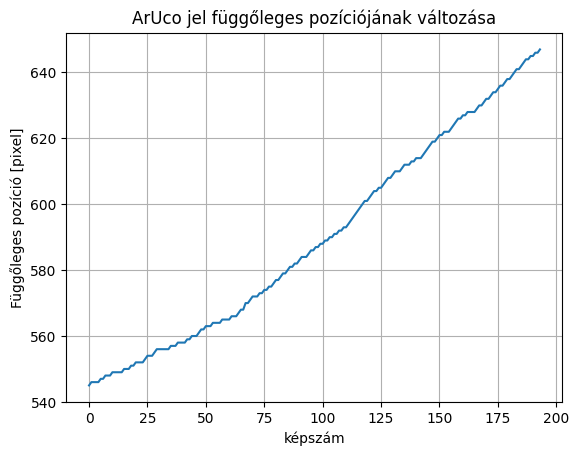

In [22]:
cap = cv2.VideoCapture('sample_data/demo.mp4')
frame = 0                 # képkocka számláló
yc = []                   # jelek y koordinátái pixelben
frames = []
while True:
  ret, img = cap.read()   # következő kép betöltése a videóból
  if ret:
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)        # kép szürkeárnyalatossá
    img_gray = cv2.undistort(gray, mtx, dist, None)     # kalibráció figyelembe vétele
    corners, ids, _ = aruco.detectMarkers(img_gray, aruco_dict, parameters=params)  # ArUco jelek keresése
    if ids:                                             # találtunk jelet?
      yc.append(img_gray.shape[1] - int(round(np.average(corners[0][0][:, 1]))))  # y koordináta
      frames.append(frame)
    frame += 1                                          # képkocka szám növelése
  else:
    break       # videó vége
plt.plot(frames, yc)
plt.title('ArUco jel függőleges pozíciójának változása')
plt.xlabel('képszám')
plt.grid()
_ = plt.ylabel('Függőleges pozíció [pixel]')

*Alakítsa át a pixeleket metrikus értékké és a képszámot idővé (a videó 2 fps-el készült, a jel valódi mérete 6.5 cm).*

##Feladatok


* Kalibrálja laptopja, fényképezőgépe kameráját. Használja az Ulyxes *charuco.py* programját!
* Készítsen a laptop kamerájával fényképeken egy mozgó ArUco jelről és határozza meg az elmozdulást a mintaillesztés vagy az ArUco jel felismerés módszerével. Használja az *imgs_aruco.py* és/vagy az *imgs_correlation.py* programot.
* Használja az Ulyxes *video_aruco.py* és/vagy *video_correlation.py* programját az ArUco jelek valós idejű megtalálására.
* Készítsen idő, x vagy idő, y grafikont a *video_aruco.py* vagy *video_correlation.py* eredményéből.
* Módosítsa a komplex példa kódját, hogy a mintaillesztés módszerét használja az ArUco jel felismerés helyett.